In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import toolz as f

from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv("data/smoking.csv")
data = data.pivot("year", "state", "cigsale")

data = data.rename(columns={c: f"state_{c}" for c in data.columns}).rename(columns={"state_3": "california"})
print(data.shape)
data.head()

(31, 39)


state,state_1,state_2,california,state_4,state_5,state_6,state_7,state_8,state_9,state_10,...,state_30,state_31,state_32,state_33,state_34,state_35,state_36,state_37,state_38,state_39
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,123.000000,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1971,95.400002,104.099998,121.000000,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
1972,101.099998,103.900002,123.500000,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
1973,102.900002,108.000000,124.400002,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
1974,108.199997,109.699997,126.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003


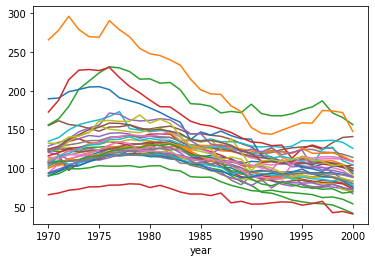

In [3]:
data.plot(legend=None);

## Synthetic Control

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, X, y):

        X, y = check_X_y(X, y)
    
        
        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X @ w-y))
        
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        self.X_ = X
        self.y_ = y
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, X):

        check_is_fitted(self)
        X = check_array(X)
        
        
        return X @ self.w_

In [5]:
model = SyntheticControl()

train = data[data.index < 1988]
test = data[data.index >= 1988]

model.fit(train.drop(columns=["california"]), train["california"])

model.w_.round(3)

array([-0.   , -0.   , -0.   ,  0.146, -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   ,  0.254, -0.   ,  0.242,  0.014, -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
        0.343, -0.   , -0.   , -0.   , -0.   , -0.   ])

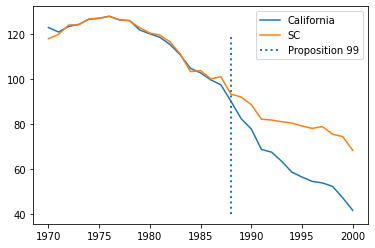

In [6]:
plt.plot(data["california"], label="California")
plt.plot(data["california"].index, model.predict(data.drop(columns=["california"])), label="SC")
plt.vlines(x=1988, ymin=40, ymax=120, linestyle=":", lw=2, label="Proposition 99")

plt.legend();

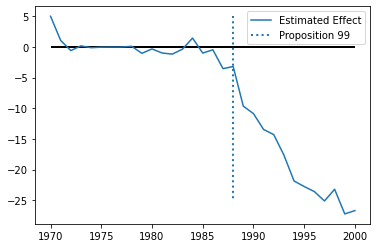

In [7]:
pred_data = data.assign(**{"residuals": data["california"] - model.predict(data.drop(columns=["california"]))})

plt.plot(pred_data["california"].index, pred_data["residuals"], label="Estimated Effect")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
plt.vlines(x=1988, ymin=5, ymax=-25, linestyle=":", lw=2, label="Proposition 99")

plt.legend();

# Conformal Inference

## Simulate Effect

In [8]:
def with_effect(df, state, effect_size, start_at, window):
    window_mask = (df.index >= start_at) & (df.index < (start_at +window))
    
    y = np.where(window_mask, df[state] + effect_size, df[state])
    
    return df.assign(**{state: y})

# Conformal Inference

In [9]:
@curry
def residuals(df, state, null, intervention_start, window, model):
    
    null_data = with_effect(df, state, -null, intervention_start, window)
            
    model.fit(null_data.drop(columns=[state]), null_data[state])
    
    
    test_mask = (null_data.index >= intervention_start) & (null_data.index < (intervention_start + window))
    
    y0_est = pd.Series(model.predict(null_data.drop(columns=[state])), index=null_data.index)
    
    residuals = null_data[state] - y0_est
    
    return pd.DataFrame({
        "y": null_data[state],
        "y_0": y0_est,
        "y_cum": null_data[state].cumsum(),
        "y_cum_window": (test_mask*null_data[state]).cumsum(),
        "residuals": residuals,
        "window": test_mask
    })[lambda d: d.index < (intervention_start + window)]
    


def p_val(resid_df):
    
    # l1 norm
    t_stats = [pd.DataFrame(np.roll(resid_df, roll, axis=0), index=resid_df.index, columns=resid_df.columns)[resid_df["window"].values]["residuals"].abs().mean()
               for roll in range(resid_df.shape[0])] 
        
    return (t_stats[0] <= np.array(t_stats)).mean()


In [10]:
model = SyntheticControl()

est_effect = residuals(data,
                       "california",
                       null=0.0,
                       intervention_start=1988,
                       window=2000-1988+1,
                       model=model)

model.w_.round(5)

array([-0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,
       -0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,
       -0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,
       -0.     ,  0.35966, -0.     , -0.     , -0.     , -0.     ,
       -0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,
       -0.     ,  0.05946,  0.58088, -0.     , -0.     , -0.     ,
       -0.     , -0.     ])

In [11]:
p_val(est_effect)

0.16129032258064516

In [12]:
def compute_p_value_grid(df, state, nulls, intervention_start, window, model, alpha=0.1):
    
    df_t0 = df[df.index < intervention_start]
    df_t1 = df[(df.index >= intervention_start) & (df.index < (intervention_start + window))]
    
    dfs = []
    
    for period, row in df_t1.iterrows():
        
        df_period = df_t0.append(row)
        
        p_vals =  {null:
                   p_val(residuals(df_period,
                                   state,
                                   null=null,
                                   intervention_start=period,
                                   window=1,
                                   model=model))
                   for null in nulls}
        
        
        dfs.append(pd.DataFrame(p_vals, index=[period]).T)
        
    return pd.concat(dfs, axis=1)
    

def conf_int(df, state, nulls, intervention_start, window, model, alpha=0.1):
    

    p_values_df = compute_p_value_grid(df,
                                       state=state,
                                       nulls=nulls,
                                       intervention_start=intervention_start,
                                       window=window,
                                       model=model,
                                       alpha=alpha)
    
    big_p_vals = p_values_df[(p_values_df > alpha)]
    
    dfs = []
    for period, columns in big_p_vals.iteritems():
        non_na = columns.dropna()
        dfs.append(pd.DataFrame({f"lower_{int(100*(1-alpha))}_ci": non_na.index.min(),
                                 f"upper_{int(100*(1-alpha))}_ci": non_na.index.max()}, index=[period]))
    
    return pd.concat(dfs)


In [13]:
model = SyntheticControl()

nulls = np.linspace(-80, 30, 100)

result = conf_int(data,
                  "california",
                  nulls=nulls,
                  intervention_start=1988,
                  window=2000-1988+1,
                  model=model)

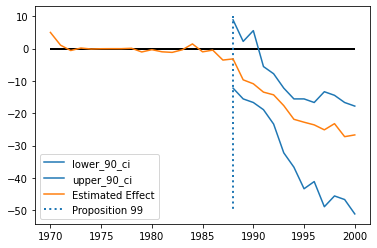

In [14]:
ax = result.plot(color="C0", label="")

ax.plot(pred_data["california"].index, pred_data["residuals"], label="Estimated Effect", color="C1")
ax.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
ax.vlines(x=1988, ymin=10, ymax=-50, linestyle=":", lw=2, label="Proposition 99")
plt.legend();

